# Reading in the files and imports

In [12]:
import pyspark.sql.functions as F
import pandas as pd 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import os 
import pickle
import re
from datetime import datetime
import requests
import pytz
import pandas as pd
import numpy as np
import ast

In [2]:
# import pyspark
# # create spark context
# sc = pyspark.SparkContext()
# # create spark session 
# spark = pyspark.sql.SparkSession(sc)

import findspark

# initialize findspark with spark directory

#ALWAYS HAVE TO BE CHANGED 
#path = "/Users/konstantinlazarov/Desktop/Big_Data/PySpark/Week_5/spark"
#path = "/Users/Artur/spark"
path = "/Users/wouterdewitte/spark/"

findspark.init(path) 

# import pyspark
import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/08 14:09:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/08 14:09:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/08 14:09:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
#reading in all keto files 
list_brands = ["healthyfood", 
               "healthylifestyle",
               "vegan",
               "keto",
               "ketodiet",
               "ketolifestyle",
               "veganism",
               "vegetarian"] 
from re import search

data_dir = ".././../data/Topic/"
tweet_files = [os.path.join(data_dir, obs) for obs in os.listdir(data_dir)]

files_brand = [file for file in tweet_files if (file.find('vegan') != -1)]
files_brand               
               
df_brand = spark.read.option("multiline","true").json(files_brand)  
df_brand.count() 
               

22/12/08 14:10:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


1827680

## Selecting the correct columns, converting types and checking for doubles 

In [4]:
df_json_sub = df_brand.select(F.col("user.name"),
                                F.col("user.screen_name"),
                                F.col("created_at"), 
                                F.col("full_text"),
                                F.col("entities.hashtags"),
                                F.col("lang"),
                                F.col("favorite_count"),
                                F.col("user.followers_count"),
                                F.col("user.friends_count"),
                                F.col("user.favourites_count"),
                                F.col("entities.urls"),
                                F.col("entities.symbols"), 
                                F.col("place.bounding_box.coordinates"),
#                                F.col("coordinates.coordinates")
                                )
#date --> time stamp variable 
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None
date_udf = F.udf(getDate, StringType())
df_json_sub = df_json_sub.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

#extract year, month, day 

df_json_sub = df_json_sub.withColumn('year', year('post_created_at'))
df_json_sub = df_json_sub.withColumn('month', month('post_created_at'))
df_json_sub = df_json_sub.withColumn('day', dayofmonth('post_created_at')) #number from 1 to 31 
df_json_sub = df_json_sub.withColumn('week', weekofyear('post_created_at')) #week number from 1 to 52 





In [5]:
#drop duplicates and retweets 
df_json_sub = df_json_sub.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates()
#sorting such when dropping later we only keep the most recent post 
df_json_sub = df_json_sub.sort("post_created_at", ascending=False)
#removing spam accounts 
df_json_sub = df_json_sub.drop_duplicates(["full_text", "screen_name"])
                        
df_json_sub.printSchema()


root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- display_url: string (nullable = true)
 |    |    |-- expanded_url: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- url: string (nullable = true)
 |-- symbols: array (nullable = true)
 |   

# 1. Data Cleaning 

In [6]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words("english")

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wouterdewitte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words("english")
# define function to remove stopwords
def remove_stops(text_tokenized):
    # remove stopwords
    text_tokenized = [word for word in text_tokenized if word not in STOPWORDS]
    return(text_tokenized)

# define function to count hashtags
def get_hashtags(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "#" in word:
            counter += 1
    return(counter) 

# define function to count mentions
def get_mentions(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "@" in word:
            counter += 1
    return(counter)

# define function to count exclamation marks
def get_exclamation_marks(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "!" in word:
            counter += 1
    return(counter)

# define function to count number of emojis used

import emojis
def emoji_counter(text):
    nr_emojis = emojis.count(text)
    return(nr_emojis)

# register functions as udf
get_hashtags_UDF = F.udf(get_hashtags, IntegerType())
get_mentions_UDF = F.udf(get_mentions, IntegerType())
get_exclamation_marks_UDF = F.udf(get_exclamation_marks, IntegerType())
emoji_counter_udf = F.udf(emoji_counter, IntegerType())
remove_stops_udf = F.udf(remove_stops, ArrayType(StringType()))


In [9]:
twitter_df = df_json_sub.withColumn("text_tokenized", F.split("full_text", " ")) \
                            .withColumn("text_cleaned", remove_stops_udf("text_tokenized")) \
                            .withColumn("num_words", F.size("text_tokenized")) \
                            .withColumn("num_hashtags", get_hashtags_UDF("text_tokenized")) \
                            .withColumn("num_mentions", get_mentions_UDF("text_tokenized")) \
                            .withColumn("num_exclamation_marks", get_exclamation_marks_UDF("text_tokenized")) \
                            .withColumn("emoji_count", emoji_counter_udf("full_text")) 
twitter_df.printSchema()


root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- display_url: string (nullable = true)
 |    |    |-- expanded_url: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- url: string (nullable = true)
 |-- symbols: array (nullable = true)
 |   

In [15]:
# define function to clean text 
import emoji

def clean_text(string):
    
    # define numbers
    NUMBERS = '0123456789'
    PUNCT = '"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'
    
    # convert text to lower case
    cleaned_string = string.lower()
    
    # remove URLS
    cleaned_string = re.sub(r'http\S+', ' ', cleaned_string)
    
    # replace emojis by words
    #cleaned_string = emojis.demojize(cleaned_string)
    cleaned_string = cleaned_string.replace(":"," ").replace("_"," ")
    cleaned_string = ' '.join(cleaned_string.split())
    
    # remove numbers
    cleaned_string = "".join([char for char in cleaned_string if char not in NUMBERS])
    
    # remove punctuation
    cleaned_string = "".join([char for char in cleaned_string if char not in PUNCT])
    
    # remove words conisting of one character (or less)
    cleaned_string = ' '.join([w for w in cleaned_string.split() if len(w) > 1])
     
    # return
    return(cleaned_string) 
clean_text_udf = F.udf(clean_text, StringType())


In [16]:
twitter_df = twitter_df.withColumn("cleaned_text", clean_text_udf(F.col("full_text")))

# 2. Sentiment Analysis  

In [17]:
#selecting english as language as only this works for rule based packages 
twitter_df = twitter_df.filter(twitter_df.lang == 'en')

## 2.1 The Vader Package 
VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores (also rule based). The sentiment score of a text can be obtained by summing up the intensity of each word in the text. Rule based packages ignore the context in which the words are used

In [20]:
#using the vaderSentiment package 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [21]:
# define the function to extract the sentiment
def get_sentiment(sentence):

    # initialize sentiment analyzer
    sid_obj = SentimentIntensityAnalyzer()

    # get sentiment dict
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # get positive sentiment score
    pos_sentiment = sentiment_dict["pos"]
    
    # return positive sentiment score
    return(pos_sentiment)

get_sentiment_udf = udf(get_sentiment, DoubleType())

In [22]:
twitter_df = twitter_df.withColumn("sentiment_vader", get_sentiment_udf(F.col("cleaned_text")))

## 2.2 TextBlob Package 

TextBlob returns polarity and subjectivity of a sentence. TextBlob is rule based sentient analysis, not using any machine learning in order to determine sentiment, only using dictionary approach. TextBlob ignores words it does not know.

**Polarity** lies between [-1,1],  -1 defines a negative sentiment and 1 defines a positive sentiment.  

**Subjectivity** quantifies the amount of personal opinion and factual information contained in the text. Subjectivity lies between [0,1]. The higher subjectivity means that the text contains personal opinion rather than factual information. 

In [25]:
#https://textblob.readthedocs.io/en/dev/
from textblob import TextBlob

In [26]:
# define function to get polarity score of text document
def get_polarity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[0]
# define function to get subjectivity score of text document
def get_subjectivity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[1]
get_polarity_udf = F.udf(get_polarity, DoubleType())
get_subjectivity_udf = F.udf(get_subjectivity, DoubleType())


In [27]:
twitter_df = twitter_df.withColumn('polarity', get_polarity_udf(F.col('cleaned_text')))\
                        .withColumn('subjectivity', get_subjectivity_udf(F.col('cleaned_text')))

## 2.3 Visualizing Sentiment 

In [28]:
#visualizing sentiment for the whole period 
# grouping by week, year and lang 
import plotly.express as px
df_sentiment = twitter_df.groupBy('year','week')\
                .agg(avg('sentiment_vader'), avg('polarity'))\
                .withColumnRenamed("avg(sentiment_vader)", "avg_sentiment_vader") \
                .withColumnRenamed("avg(polarity)", "avg_polarity") \
                .sort('year', 'week', ascending = True)
df_sentiment = df_sentiment.select(concat_ws('_',df_sentiment.year, df_sentiment.week)\
                            .alias('date'), 'avg_sentiment_vader', 'avg_polarity').toPandas()

df_sentiment

,date,avg_sentiment_vader,avg_polarity
0,2021_43,0.134149,0.129711
1,2021_44,0.144773,0.168057
2,2021_48,0.127583,0.160417
3,2021_49,0.132764,0.125088
4,2021_50,0.169860,0.221397
5,2021_51,0.169269,0.231307
6,2021_52,0.155547,0.178460
7,2022_1,0.160738,0.220258
8,2022_2,0.155495,0.205056
9,2022_3,0.146509,0.205497


In [29]:
fig = px.line(df_sentiment, x='date', y=df_sentiment.columns[1:3])

    # Add figure title
fig.update_layout(
        title_text="Sentiment over time ",
        title_x = 0.5
    )

    # add axes
fig.update_xaxes(title_text="<b>Date</b>")
fig.update_yaxes(title_text="<b>Sentiment</b>")

fig.show()

### 2.3.1 visualizing sentiment based on coordinates 



In [30]:
twitter_df.filter(F.col("coordinates").isNull()).count()\
        /twitter_df.count()*100 
#97 procent of the data does not have a coordinate 

96.972918162278

In [31]:
#select the coordinates that are not null 
co_df = twitter_df.filter(twitter_df.coordinates.isNotNull())
co_df.count()

14210

In [32]:
co_df = co_df.select('coordinates', 'sentiment_vader', 'polarity')
co_df.printSchema()

root
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |-- sentiment_vader: double (nullable = true)
 |-- polarity: double (nullable = true)



In [33]:
co_df = co_df.withColumn('element1', co_df.coordinates.getItem(0))
co_df = co_df.withColumn('element2', co_df.element1.getItem(0))
co_df = co_df.withColumn('long', co_df.element2.getItem(0))
co_df = co_df.withColumn('lat', co_df.element2.getItem(1))


In [34]:
co_df.select('long','lat').show(5)

+-------------------+-----------------+
|               long|              lat|
+-------------------+-----------------+
|-121.01971798381265|47.20865872393696|
|          -0.173706|         50.80835|
|         -4.0649355|       55.8920205|
|         -83.204418|        42.474131|
|        -84.5355341|        33.609487|
+-------------------+-----------------+
only showing top 5 rows



In [35]:
co_df = co_df.select('long', 'lat', 'sentiment_vader', 'polarity').toPandas()
co_df

,long,lat,sentiment_vader,polarity
0,-121.019718,47.208659,0.000,0.000000
1,-0.173706,50.808350,0.077,-0.183333
2,-4.064935,55.892021,0.187,0.053333
3,-83.204418,42.474131,0.172,0.000000
4,-84.535534,33.609487,0.000,0.016667
...,...,...,...,...
14205,-79.834550,40.401140,0.292,0.338447
14206,-121.074342,37.594850,0.194,0.750000
14207,-118.668404,33.704538,0.137,0.193750
14208,-100.901447,35.014856,0.225,0.190755


In [36]:
#https://towardsdatascience.com/easiest-way-to-plot-on-a-world-map-with-pandas-and-geopandas-325f6024949f 
import matplotlib.pyplot as plt
import geopandas as gpd

In [37]:
co_df[['sentiment_vader', 'polarity']].describe()

,sentiment_vader,polarity
count,14210.000000,14210.000000
mean,0.146552,0.177213
std,0.143929,0.317526
min,0.000000,-1.000000
25%,0.000000,0.000000
50%,0.127000,0.100000
75%,0.241000,0.375000
max,1.000000,1.000000


In [38]:
#making 3 levels of sentiment 
def vader_cat(value):
    if value < 0.05: 
        return 'low sentiment'
    if (value >= 0.05) &(value<0.24): 
        return 'average sentiment'
    return 'high sentiment'
co_df['vader_categorical'] = co_df['sentiment_vader'].map(vader_cat)

def polarity_cat(value):
    if value < 0: 
        return 'low sentiment'
    if (value >= 0.00) &(value<0.39): 
        return 'average sentiment'
    return 'high sentiment'
co_df['polarity_categorical'] = co_df['polarity'].map(polarity_cat)

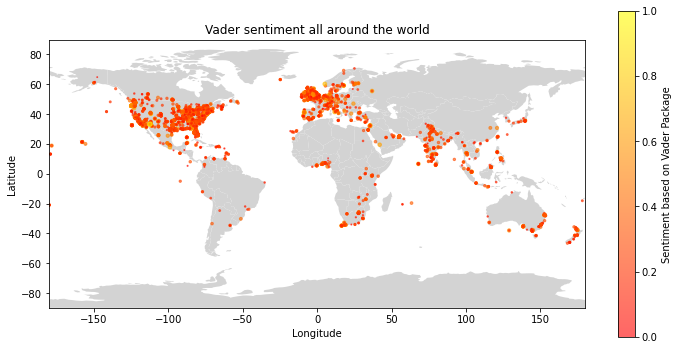

In [39]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Impact Energy data with a color map
x = co_df['long']
y = co_df['lat']
z = co_df['sentiment_vader']
plt.scatter(x, y, s=20*z, c=z, alpha=0.6, vmin=0, vmax=1,
            cmap='autumn')
plt.colorbar(label='Sentiment based on Vader Package')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])


plt.title("Vader sentiment all around the world")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/Users/wouterdewitte/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning:

invalid value encountered in sqrt



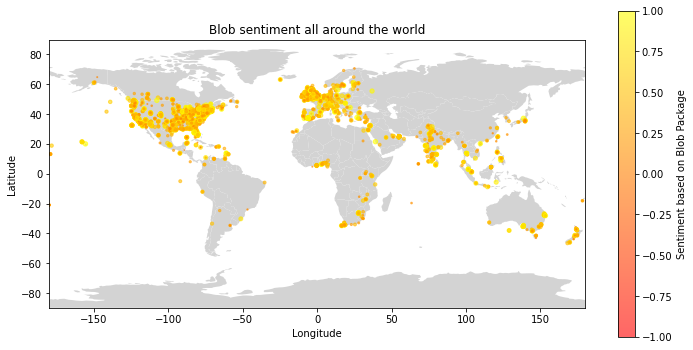

In [40]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Impact Energy data with a color map
x = co_df['long']
y = co_df['lat']
z = co_df['polarity']
plt.scatter(x, y, s=20*z, c=z, alpha=0.6, vmin=-1, vmax=1,
            cmap='autumn')
plt.colorbar(label='Sentiment based on Blob Package')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])


plt.title("Blob sentiment all around the world")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [41]:
#possible improvements: make it in plotly https://plotly.com/python/scatter-plots-on-maps/ 


# 3. Making a WorldCloud

In [42]:
#make a wordcloud on the cleaned_text variable  
twitter_df.select('text_cleaned').show(5)

+--------------------+
|        text_cleaned|
+--------------------+
|[!, We, open, 10a...|
|[!!, Daily, Updat...|
|[!love, !iq, !wad...|
|[", DID, YOU, KNO...|
|[", Nature's, Int...|
+--------------------+
only showing top 5 rows



In [44]:
pip install WordCloud

     |████████████████████████████████| 160 kB 2.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
from wordcloud import WordCloud

In [46]:
cleanewd_text = twitter_df.select('text_cleaned').toPandas()

In [47]:
cleanewd_text['text_cleaned']

0         [!, We, open, 10am-9pm, today, tomorrow!!, Muc...
1         [!!, Daily, Updates, !!\n\nA, taste, Vegan, Fo...
2         [!love, !iq, !waddup, Building, time, Sketch, ...
3         [", DID, YOU, KNOW, ?"\n\n#senoritacosmetics, ...
4         [", Nature's, Interconnection, ", \n\nCommissi...
                                ...                        
469424    [🥧, brEAThe, &amp;, @Veganuary, 🥧, #DYK, aweso...
469425    [🥧, brEAThe, Kitchen, Appreciates, 🥧, We, love...
469426    [🥩💀, A, VEAL, CALF, IS, TAKEN, AWAY, FROM, HIS...
469427    [🦪🖤🌈🌱, Vegan, Kitchen:, Low, fat,, high, prote...
469428    [🧡, Discover, orange, modern, art, prints, #et...
Name: text_cleaned, Length: 469429, dtype: object

In [48]:
# convert text corpus to large string in order to use the WordCLoud package 
bad_words = ['vegan', 'https']
large_string = ""
for doc in cleanewd_text['text_cleaned']:
    # remove stop words
    cleaned_doc = [word for word in doc if word not in STOPWORDS]
    #remove redundant and specific words to vegan 
    cleaned_doc = [word for word in cleaned_doc if word not in bad_words]
    # remove single characters
    cleaned_doc = [word for word in cleaned_doc if len(word) > 3]
    # add to large string
    large_string += " ".join(cleaned_doc)

In [49]:
#replace bad_words from large string manually 
large_string = large_string.replace(" vegan", " ")
large_string = large_string.replace("vegan ", " ")
large_string = large_string.replace(" vegan ", " ")
large_string = large_string.replace("vegan", " ")
large_string = large_string.replace("Vegan", " ")
large_string = large_string.replace("https", " ")

In [50]:
large_string.count("Vegan")

0

In [51]:
# generate wordcloud
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=1, 
                      background_color='white', 
                      colormap='Set2', 
                      collocations=False, 
                     min_word_length=4, 
                     collocation_threshold=3).generate(large_string)

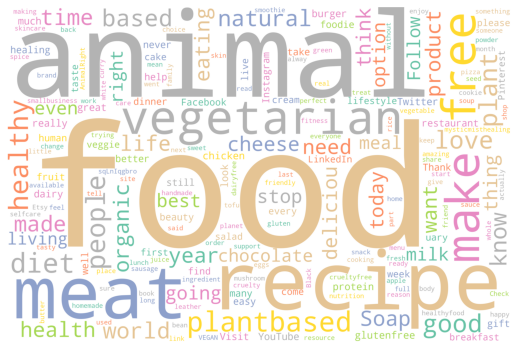

In [52]:
# plot the wordcloud                   
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [53]:
#get the values for each term 
sorted(wordcloud.words_.items(), key=lambda x:x[1], reverse=True)

[('food', 1.0),
 ('animal', 0.5725025187940789),
 ('recipe', 0.5462605595597922),
 ('meat', 0.43929318763078357),
 ('vegetarian', 0.3843912268464698),
 ('free', 0.37521506626365964),
 ('make', 0.37295202666046656),
 ('plantbased', 0.36546539564442376),
 ('diet', 0.3544137022397892),
 ('healthy', 0.3360303805316593),
 ('people', 0.3334573355033713),
 ('plant', 0.30151127644733783),
 ('good', 0.2974037045648299),
 ('love', 0.2880105401844532),
 ('based', 0.2646206308610401),
 ('know', 0.24592730372781524),
 ('natural', 0.2433387584282725),
 ('world', 0.2391846857320003),
 ('time', 0.23709214911260948),
 ('made', 0.23101604278074866),
 ('organic', 0.22126637216151282),
 ('life', 0.21646128807254128),
 ('Soap', 0.21632178563124854),
 ('year', 0.21548477098349222),
 ('health', 0.21297372704022322),
 ('product', 0.21024567929938773),
 ('eating', 0.20649461365573898),
 ('need', 0.20350306130357282),
 ('cheese', 0.19831047043323258),
 ('want', 0.19348988607300627),
 ('think', 0.192544369526466

# 3. Translating to english (failed) 




Tried multile translation packages: googletrans,translate, spraknlp.pretrained but we faced computational limitations, even on small dataset. Trying to work in spark gave us an imediate error (which ze communicated to the assistant). Below is our most effective approach but only works on really small datasets, but is no scalable to large datasets due to memory constraints on our personal computers

Methodology: 
- create a pyspark df for the non english tweets: non_english_df
- convert this pyspark df to a pd df : non_english_df_pd 
- apply the googletrans function to this pandas df and apply the udf to the pyspark df to get the correct StructType 
- convert the non_english_df_pd back to a pyspark df using the StructType callend ndf 
- merge this non_english_df back to the twitter_df 

In [ ]:
#only slect the non english tweets in the dataset 
non_english_df = twitter_df.filter(twitter_df.lang != 'en')
non_english_df.count() 

#FIRST DO THE FOLLOWING PIP INSTALL 
#pip install googletrans-py
from pprint import pprint
from googletrans import Translator, constants

translator = Translator() 
translation = translator.translate("nakamuraff これはパッと見では分からないですね💦", dest='en')
#print(f"{translation.origin} ({translation.src}) --> {translation.text} ({translation.dest})")


def translate(tweet):
    if len(tweet)!=0:
        translator = Translator() 
        translation = translator.translate(tweet, dest = 'en')
        return(translation.text)
    return None

translate_udf = F.udf(translate, StringType())
#test if code works 
translate("alltså kan nyheterna kockarna tillaga nåt annat än carbssockerfylld sk mat enda gång carbworld ketolifestyle")


#this is used so the non_english has the correct StructType 
non_english_df =  non_english_df.withColumn('english_tweet', translate_udf('cleaned_text'))

non_english_df_pd = non_english_df.toPandas()

non_english_df_pd["english_tweet"] = non_english_df_pd.apply(lambda x: translate(x['cleaned_text']), axis = 1)

ndf = spark.createDataFrame(non_english_df_pd, schema=non_english_df.schema)

#making sure the that the same StructType is present 
#dropping cleaned text 
ndf = ndf.drop('cleaned_text')
#renaming english tweet to cleaned_text 
ndf = ndf.withColumnRenamed('english_tweet', 'cleaned_text')

english_df = twitter_df.filter(twitter_df.lang == 'en') 

#merging the 2 dataframes back together
twitter_df = english_df.union(ndf)
